In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
import joblib

### Регрессии IC50

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
# Загрузка данных
data = pd.read_csv('data/data_cl.csv')

In [ ]:
data.head()

In [ ]:
data.info()

In [24]:
if data.isnull().sum().sum() > 0:
    print('Есть пропущенные значения')

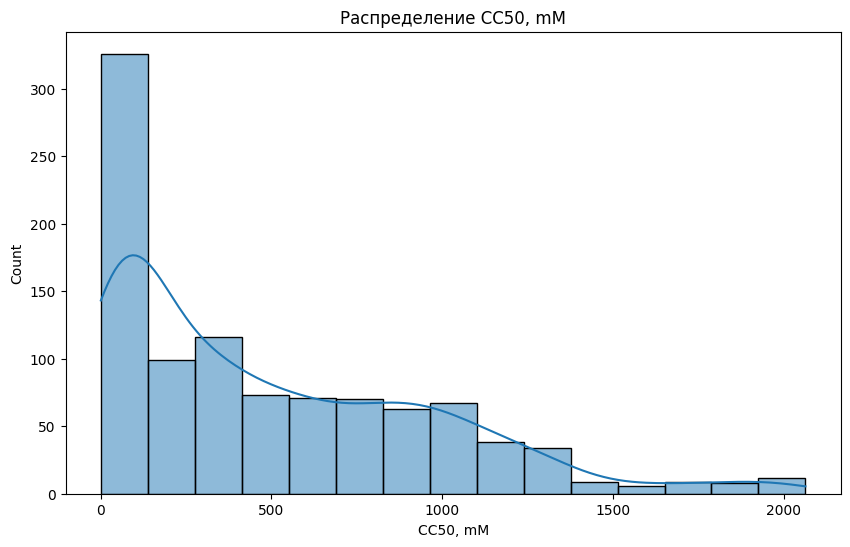

In [26]:
# Визуализация распределения целевой переменной IC50
plt.figure(figsize=(10, 6))
sns.histplot(data['CC50, mM'], kde=True)
plt.title('Распределение СС50, mM')
plt.savefig('results/cc50_distribution.png')
plt.show()

In [48]:
# Разделение на признаки и целевую переменную
X = data.drop(['CC50, mM', 'Unnamed: 0'], axis=1)
y_ic50 = data['CC50, mM']

# Масштабирование признаков
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на train/test (для финальной оценки)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_ic50, test_size=0.2, random_state=42)

### Модель


In [49]:
def evaluate_models(models, X, y, cv=5):
    """
    Функция для оценки метрик  
    """
    results = {}
    
    for name, model in models.items():
        # Оценка с использованием отрицательной средней квадратичной ошибки
        mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
        results[name] = {
            'mean_mse': -mse_scores.mean(),
            'std_mse': mse_scores.std(),
            'all_mse_scores': -mse_scores
        }
        
        # Оценка с использованием средней абсолютной ошибки
        mae_scorer = make_scorer(mean_absolute_error)
        mae_scores = cross_val_score(model, X, y, cv=cv, scoring=mae_scorer)
        results[name]['mean_mae'] = mae_scores.mean()
        results[name]['std_mae'] = mae_scores.std()
        results[name]['all_mae_scores'] = mae_scores
        
        # Оценка с использованием R_2
        r2_scorer = make_scorer(r2_score)
        r2_scores = cross_val_score(model, X, y, cv=cv, scoring=r2_scorer)
        results[name]['mean_r2'] = r2_scores.mean()
        results[name]['std_r2'] = r2_scores.std()
        results[name]['all_r2_scores'] = r2_scores

    return results

**Регрессия**

In [50]:
# Инициализация моделей
reg_models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'XGBoost': XGBRegressor(random_state=42)
}

In [51]:
reg_results = evaluate_models(reg_models, X_train, y_train)

In [52]:
# Вывод результатов
print("Результаты регрессии:")
for name, res in reg_results.items():
    print(f"{name}:")
    print(f"  Средняя MSE: {res['mean_mse']:.4f}, стандартное отклонение: {res['std_mse']:.4f}")
    print(f"  Средняя MAE: {res['mean_mae']:.4f}, стандартное отклонение: {res['std_mae']:.4f}")
    print(f"  Средний R²: {res['mean_r2']:.4f}, стандартное отклонение: {res['std_r2']:.4f}")

Результаты регрессии:
Linear Regression:
  Средняя MSE: 179455.7250, стандартное отклонение: 27148.0167
  Средняя MAE: 332.8122, стандартное отклонение: 13.5813
  Средний R²: 0.1742, стандартное отклонение: 0.0403
Random Forest:
  Средняя MSE: 66981.8069, стандартное отклонение: 25026.1832
  Средняя MAE: 142.9900, стандартное отклонение: 25.5236
  Средний R²: 0.6982, стандартное отклонение: 0.0914
SVR:
  Средняя MSE: 233817.6213, стандартное отклонение: 29583.0243
  Средняя MAE: 364.1830, стандартное отклонение: 14.8665
  Средний R²: -0.0782, стандартное отклонение: 0.0309
KNN:
  Средняя MSE: 164587.9535, стандартное отклонение: 23806.3988
  Средняя MAE: 287.9583, стандартное отклонение: 19.0182
  Средний R²: 0.2332, стандартное отклонение: 0.1185
XGBoost:
  Средняя MSE: 66556.3811, стандартное отклонение: 27009.1213
  Средняя MAE: 133.3069, стандартное отклонение: 23.3576
  Средний R²: 0.7005, стандартное отклонение: 0.1045


**Вывод**

Наилучшие результаты по метрике R_2 также у Random Forest (0.6982) и XGBoost (0.7005), что говорит о том, что они способны объяснить большую часть вариации целевой переменной

### Подбор гиперпараметров для лучших моделей

Для регрессии Random Forest

In [57]:
# Параметры для поиска
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

In [58]:
# Поиск по сетке
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [59]:
# Лучшие параметры
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший MSE: {-grid_search.best_score_:.4f}")

Лучшие параметры: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Лучший MSE: 66387.1615


In [60]:
# Обучение финальной модели
best_reg_model = grid_search.best_estimator_

### Оценка на тесте 

In [67]:
# Предсказания
y_pred = best_reg_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

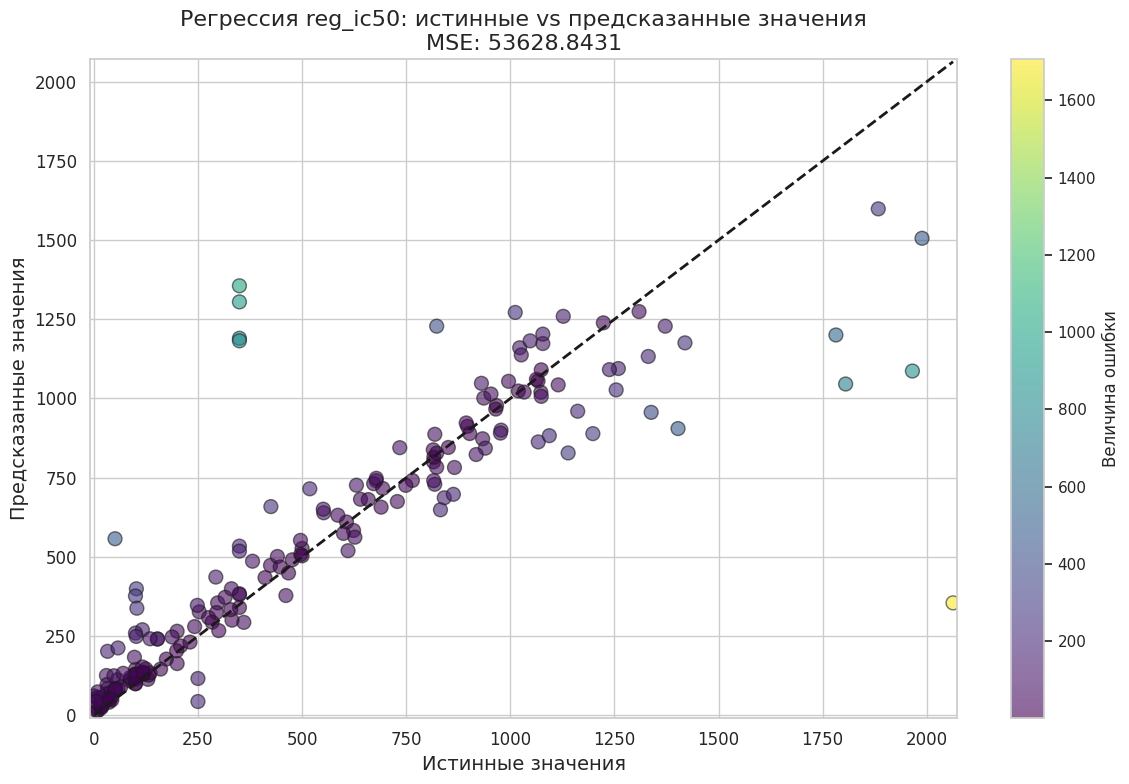

In [68]:
# Визуализация
plt.figure(figsize=(12, 8))
plt.scatter(y_test, y_pred, alpha=0.6, c=np.abs(y_test - y_pred), s=100, cmap='viridis', edgecolors='k')
plt.colorbar(label='Величина ошибки')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', linewidth=2)
plt.xlabel('Истинные значения', fontsize=14)
plt.ylabel('Предсказанные значения', fontsize=14)
plt.title(f'Регрессия reg_ic50: истинные vs предсказанные значения\nMSE: {mse:.4f}', fontsize=16)
plt.grid(True)
plt.xlim([y_test.min() - 10, y_test.max() + 10])
plt.ylim([y_test.min() - 10, y_test.max() + 10])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('results/regression_results_reg_cc50.png')
plt.show()

### Анализ важности признаков

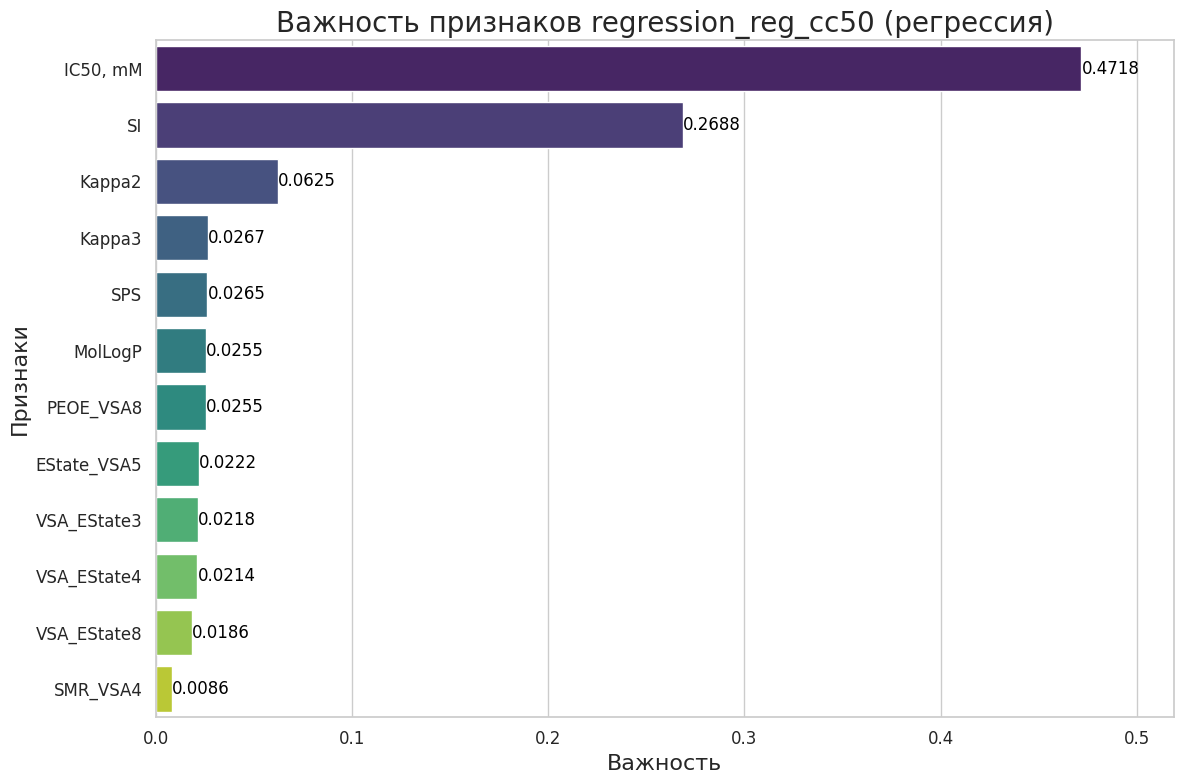

Выводы о важности признаков:
Наиболее важные признаки для модели регрессии:
IC50, mM: Важность = 0.4718
SI: Важность = 0.2688
Kappa2: Важность = 0.0625
Kappa3: Важность = 0.0267
SPS: Важность = 0.0265
MolLogP: Важность = 0.0255
PEOE_VSA8: Важность = 0.0255
EState_VSA5: Важность = 0.0222
VSA_EState3: Важность = 0.0218
VSA_EState4: Важность = 0.0214
VSA_EState8: Важность = 0.0186
SMR_VSA4: Важность = 0.0086

Наиболее важный признак: IC50, mM с важностью 0.4718
Наименее важный признак: SMR_VSA4 с важностью 0.0086


In [69]:
if hasattr(best_reg_model, 'feature_importances_'):
    importances = best_reg_model.feature_importances_
    feature_names = X.columns
    features_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    features_df = features_df.sort_values('Importance', ascending=False)

    # Настройка стиля
    sns.set(style='whitegrid')

    plt.figure(figsize=(12, 8))
    bar_plot = sns.barplot(x='Importance', y='Feature', data=features_df, palette='viridis')

    # Добавление значений на столбцах
    for index, value in enumerate(features_df['Importance']):
        bar_plot.text(value, index, f'{value:.4f}', color='black', ha="left", va="center")

    plt.title('Важность признаков regression_reg_cc50 (регрессия)', fontsize=20)
    plt.xlabel('Важность', fontsize=16)
    plt.ylabel('Признаки', fontsize=16)
    plt.xlim(0, features_df['Importance'].max() * 1.1)  # Увеличение лимита оси X
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    plt.tight_layout()
    plt.savefig('results/feature_importance_regression_reg_сc50.png')
    plt.show()

    # Выводы
    print("Выводы о важности признаков:")
    print("Наиболее важные признаки для модели регрессии:")
    for i, row in features_df.iterrows():
        print(f"{row['Feature']}: Важность = {row['Importance']:.4f}")

    # Дополнительные выводы
    most_important_feature = features_df.iloc[0]
    print(f"\nНаиболее важный признак: {most_important_feature['Feature']} с важностью {most_important_feature['Importance']:.4f}")
    
    # Можно добавить вывод о том, какие признаки менее важны
    least_important_feature = features_df.iloc[-1]
    print(f"Наименее важный признак: {least_important_feature['Feature']} с важностью {least_important_feature['Importance']:.4f}")

In [66]:

# Сохранение моделей
joblib.dump(best_reg_model, 'results/best_regression_model_reg_сc50.pkl')


# Сохранение результатов
results_df = pd.DataFrame({'Regression MSE': [reg_results[model]['mean_mse'] for model in reg_results]})

results_df.to_csv('results/model_reg_сc50.csv', index=True)
